# Estimating the effects of frequency and polysemy on semantic change

This notebook contains code to replicate the main result of [Diachronic Word Embeddings Reveal Statistical Laws of Semantic Change](http://arxiv.org/pdf/1605.09096.pdf)

This notebook assumes that you have downloaded all the full historical datasets from [link to data](http://TODO) and that you have put the datasets for all the different languages/corpora under the same root directory, e.g., (.../root_dir/eng-all/)

In [7]:
#Basic imports
# You need to modify the DATA_DIR path below. 
import sys

import matplotlib
import collections
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os

DATA_DIR = "ROOT_DIR"

import ioutils as util
from cooccurrence import matstore
from statutils import plothelper, changepoint, trendestimator, seriesanalysis
from vecanalysis.sequentialexplicit import SequentialExplicit
from statutils import mixedmodels
import seaborn as sns
import statsmodels.api as sm
from misc.fastfreqdist import CachedFreqDist

%matplotlib inline

### Loading the data

First we load the data. Note the this is a lot of data so this may take a while and requires a lot of RAM. You might need to reduce the number of datasets in the cell below.

In [4]:
datasets = ["eng-all", "eng-fiction-all", "ger-all", "fre-all", "chi-sim-all", "coha-word", "coha-lemma"]

In [6]:
# load the estimates of semantic change
volstats = {}
for dataset in datasets:
    volstats[dataset] = util.load_pickle(DATA_DIR.format(dataset) + "volstats/vols.pkl")

NameError: name 'os' is not defined

In [ ]:
# load the historical word frequencies
freqs = {}
for dataset in datasets:
    freqs[dataset] = util.load_pickle(DATA_DIR.format(dataset) + "freqs.pkl"

In [10]:
# load the historical POS tags
pos = collections.defaultdict(dict)
for dataset in datasets:
    for year_file in os.listdir(DATA_DIR.format(dataset) + "/pos"):
        if "counts" in year_file:
            continue
        year = int(year_file.split("-")[0])
        pos[dataset][year] = util.load_pickle(DATA_DIR.format(dataset) + "pos/" + year_file)

In [20]:
# load the network based co-occurrence scores
netstats = {}
clust_meds = {}
for dataset in datasets:
    netstats[dataset] = util.load_pickle(DATA_DIR.format(dataset) + "/netstats/full-nstop_nproper-top10000.pkl")["bclust"]
    clust_meds[dataset] = seriesanalysis.get_series_median(netstats[dataset], volstats[dataset].keys(), 
                                                 start_year=np.min(pos[dataset].keys()), end_year=np.max(pos[dataset].keys()), year_inc=10)

In [107]:
# load sets of all words that occurred more than 500 times
# really only matters for the COHA datasets
valid_words = collections.defaultdict(dict)
min_count = 500
for dataset in datasets:
    for year in pos[dataset].keys():
        valid_words[dataset][year] = set(util.words_above_count(DATA_DIR.format(dataset) + "/counts/", year, min_count))

In [117]:
# This his helper code to set up the Pandas data frames
main_tags = set(["VERB", "NOUN", "ADJ", "ADV"])
make_pos = lambda tag : "ADJ" if tag=="jj" else "ADV" if tag=="rr" else "NOUN" if tag=="nn" else "VERB" if tag=="vv" else tag
def make_df(volstats, dataset):
    if "coha" in dataset:
        offset = 5
    else:
        offset = 1
    feature_dict = {"freq" : (lambda word, year : float('nan') if not word in valid_words[dataset][year] else np.log(freqs[dataset][word][year-10])),
                 "vol" : (lambda word, year : np.log(np.arccos(volstats[dataset][word][year]))),
                "clust" : (lambda word, year : -np.log(netstats[dataset][word][year-10]) + np.log(clust_meds[dataset][(year-int(np.min(pos[dataset].keys()))) / 10 - 1])),
                "pos" : (lambda word, year : float('nan') if not word in pos[dataset][year] or not make_pos(pos[dataset][year][word]) in main_tags else make_pos(pos[dataset][year][word])), 
                }
    return mixedmodels.make_data_frame(volstats[dataset].keys(), sorted(pos[dataset].keys())[offset:], feature_dict)

### Running the regressions

Now that the data is loaded (finally..). We can run the regressions. 
We do this using pandas and statsmodels.

In [118]:
# Construct the pandas data frames
volstat_dfs = {}
for dataset in datasets:
    df = make_df(volstats, dataset)
    df["vol"] = (df["vol"] - np.mean(df["vol"])) / np.std(df["vol"])
    volstat_dfs[dataset] = df

coha-lemma
coha-word


In [119]:
# Run the mixed model regressions.
# This can take a while (hours)
formula = "vol ~ C(year) + freq + clust"
v1_res = {}
for dataset in datasets:
    df = volstat_dfs[dataset]
    v1_res[dataset] =  mixedmodels.run_lmm(formula, df, groups=df["word"], reml=True)

In [120]:
# Extract the coefficents that we are interested in
freq_coefs = {}
freq_errs = {}
for name, res in v1_res.iteritems():
    freq_coefs[name] = res.fe_params["freq"]
    freq_errs[name] = res.bse["freq"]

clust_coefs = {}
clust_errs = {}
for name, res in v1_res.iteritems():
    clust_coefs[name] = res.fe_params["clust"]
    clust_errs[name] = res.bse["clust"]

In [128]:
clust_coefs

{'chi-sim-all': 0.49970876935555403,
 'coha-lemma': 0.37886518834014704,
 'coha-word': 0.41948004921927362,
 'eng-all': 0.69066927150356028,
 'eng-fiction-all': 0.501691957500491,
 'fre-all': 0.76808095300514911,
 'ger-all': 0.57191349854546047}

### Plotting the data

Finally we can plot the data!

In [122]:
# Setting up the plot style.
# Uses seaborn
sns.set_style("whitegrid")
plt.rcParams["font.sans-serif"].insert(0, "Helvetica")
plt.rcParams["lines.linewidth"] = 1.0
plt.rcParams["patch.linewidth"] = 1.0
plt.rcParams["grid.linewidth"] = 0.4
plt.rcParams["grid.color"] = "gray"
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["axes.linewidth"] = 1.0
plt.rcParams["axes.labelsize"] =  9
plt.rcParams["axes.titlesize"] = 11
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.major.size"] = 4
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 4
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 2
plt.rcParams["ytick.minor.size"] = 2
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["legend.fontsize"] = 10
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('text', usetex=True)
def clean_plot(axis):
    axis.xaxis.set_ticks_position('bottom')
    axis.yaxis.set_ticks_position('left')
    axis.minorticks_on()

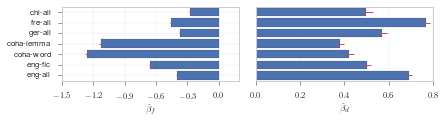

In [124]:
plt.rcParams["figure.figsize"] = (6.29, 1.8)
labels = ["eng-all", "eng-fiction-all", "coha-word", "coha-lemma", "ger-all", "fre-all", "chi-sim-all"]
arrs = np.array(range(len(labels))) + 0.5
_, axs = plt.subplots(1,2)
axs[0].barh(arrs,[freq_coefs[d] for d in labels],xerr=[1.96*freq_errs[d] for d in labels], align="center", ecolor=sns.color_palette()[2], linewidth=0.1)
axs[0].xaxis.set_ticks_position("bottom")
axs[0].yaxis.set_ticks_position("left")
axs[0].set_yticks(arrs)
plot_labels = ["eng-all", "eng-fic", "coha-word", "coha-lemma", "ger-all", "fre-all", "chi-all"]
axs[0].set_yticklabels(plot_labels)
axs[0].set_xticks(np.arange(-1.5, 0.2, 0.3))
axs[1].barh(arrs,[clust_coefs[d] for d in labels], align="center", xerr=[1.96*clust_errs[d] for d in labels], ecolor=sns.color_palette()[2], linewidth=0.1)
axs[1].xaxis.set_ticks_position("bottom")
axs[1].yaxis.set_ticks_position("left")
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_xticks(np.arange(0, 1.0, 0.2))
axs[0].set_xlabel(r"$\hat{\beta}_{f}$")
axs[1].set_xlabel(r"$\hat{\beta}_{d}$")
plt.tight_layout()
plt.savefig("full-effects.pdf")